In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from faker import Faker
import missingno as msno
from thefuzz import fuzz
from fuzzywuzzy import process
import recordlinkage

# 1. Common Data Problems

## a. Data Type Constraints

### Example 1

In [2]:
data = {'SalesOrderID':[43659,43660,45124,44215],
        'Revenue':['23153$','14522$','15245$','9587$'],
        'Quantity':[12,2,5,1]}
sales = pd.DataFrame(data)
sales.head(2)

,SalesOrderID,Revenue,Quantity
0,43659,23153$,12
1,43660,14522$,2


In [3]:
# Get data types of columns
sales.dtypes

SalesOrderID     int64
Revenue         object
Quantity         int64
dtype: object

Now if we want to see the total revenue and apply the sum method , the result would be a concatinated string rather than a numerical sum of all revenue values from all the rows :

In [4]:
sales['Revenue'].sum()

'23153$14522$15245$9587$'

As a solution we remove the $ sign first and then change the datatype to ‘int’ before performing the sum operation :

In [5]:
sales['Revenue'] = sales['Revenue'].str.strip('$')
sales

,SalesOrderID,Revenue,Quantity
0,43659,23153,12
1,43660,14522,2
2,45124,15245,5
3,44215,9587,1


In [6]:
sales['Revenue'] = sales['Revenue'].astype('int')

In [7]:
sales['Revenue'].sum()

62507

### Example 2

We are saving marriage_status values as numbers, denoting :

0 = Never married 1 = Married 2 = Separated 3 = Divorced

In [8]:
df = sales.copy()
df['marriage_status'] = [3,1,2,0]
df.head()

,SalesOrderID,Revenue,Quantity,marriage_status
0,43659,23153,12,3
1,43660,14522,2,1
2,45124,15245,5,2
3,44215,9587,1,0


Then we try to look at the statistical summary of this column :

In [9]:
df['marriage_status'].describe()

count    4.000000
mean     1.500000
std      1.290994
min      0.000000
25%      0.750000
50%      1.500000
75%      2.250000
max      3.000000
Name: marriage_status, dtype: float64

This is noway useful in understanding the distribution of our concerned variable in the dataset so we first need to convert this to a int type variable.

In [10]:
df["marriage_status"] = df["marriage_status"].astype('category')
df.astype('object').describe()

,SalesOrderID,Revenue,Quantity,marriage_status
count,4,4,4,4
unique,4,4,4,4
top,43659,23153,12,3
freq,1,1,1,1


In [11]:
df.dtypes

SalesOrderID          int64
Revenue               int32
Quantity              int64
marriage_status    category
dtype: object

## b. Data Range Constraints

### Example 3

In [12]:
data = {'movie_name':['a','b','c','d','e','f','g'],
        'avg_rating':[5,3,4,3,2,6,1]}
df = pd.DataFrame(data)
df

,movie_name,avg_rating
0,a,5
1,b,3
2,c,4
3,d,3
4,e,2
5,f,6
6,g,1


One useful way to have a quick and easy way to view corrupt data which is falling out of the expected range is to visualize that column :

Text(0.5, 1.0, 'Average rating of movies (1-5)')

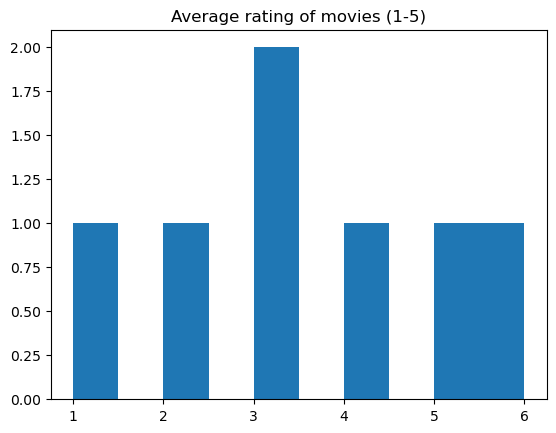

In [13]:
plt.hist(df['avg_rating'])
plt.title('Average rating of movies (1-5)')

We see here that few values are falling at 6 which is out of range. Many ways exist to deal with these out of range values, like imputing the rows, setting them to value 5 , or setting to an average rating value etc, which depends of the business case and problem we are trying to solve through this particular analysis.

We filter out the wrong values using following code :

In [14]:
df[df['avg_rating']>5]

,movie_name,avg_rating
5,f,6


Next, we Drop values using filtering

In [15]:
# Fisrt way
df2 = df[df['avg_rating'] <= 5]
df2

,movie_name,avg_rating
0,a,5
1,b,3
2,c,4
3,d,3
4,e,2
6,g,1


In [16]:
#Second way
df3 = df.copy()
df3.drop(df3[df3['avg_rating'] > 5].index, inplace=True)
df3

,movie_name,avg_rating
0,a,5
1,b,3
2,c,4
3,d,3
4,e,2
6,g,1


Another way is to replace those values to max value i.e. 5

In [17]:
df4 = df.copy()
df4.loc[df4['avg_rating'] > 5, 'avg_rating'] = 5
df4

,movie_name,avg_rating
0,a,5
1,b,3
2,c,4
3,d,3
4,e,2
5,f,5
6,g,1


### Example 4

In [18]:
data = {'subscription_date':['01/05/2021','02/02/2024','22/11/2022','12/12/2024',
                            '25/06/2024','13/08/2024','02/02/2023'],
        'avg_rating':[5,3,4,3,2,6,1]}
df = pd.DataFrame(data)
df

,subscription_date,avg_rating
0,01/05/2021,5
1,02/02/2024,3
2,22/11/2022,4
3,12/12/2024,3
4,25/06/2024,2
5,13/08/2024,6
6,02/02/2023,1


In [19]:
today_date = dt.date.today()
df[df['subscription_date'] > today_date.strftime('%d/%m/%Y')]

,subscription_date,avg_rating


To solve for this we first check the data type of the concerned column :

In [20]:
df.dtypes

subscription_date    object
avg_rating            int64
dtype: object

We see that subscription_date column has object datatype hence string type values, so first we need to convert them to date type:

In [21]:
df['subscription_date'] = pd.to_datetime(df['subscription_date']).dt.date

C:\Users\oyedi\AppData\Local\Temp\ipykernel_27228\1447835201.py:1: UserWarning: Parsing '22/11/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['subscription_date'] = pd.to_datetime(df['subscription_date']).dt.date
C:\Users\oyedi\AppData\Local\Temp\ipykernel_27228\1447835201.py:1: UserWarning: Parsing '25/06/2024' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['subscription_date'] = pd.to_datetime(df['subscription_date']).dt.date
C:\Users\oyedi\AppData\Local\Temp\ipykernel_27228\1447835201.py:1: UserWarning: Parsing '13/08/2024' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['subscription_date'] = pd.to_datetime(df['subscription_date']).dt.date


In [22]:
df.dtypes

subscription_date    object
avg_rating            int64
dtype: object

In [23]:
df

,subscription_date,avg_rating
0,2021-01-05,5
1,2024-02-02,3
2,2022-11-22,4
3,2024-12-12,3
4,2024-06-25,2
5,2024-08-13,6
6,2023-02-02,1


In [24]:
df[df['subscription_date'] > today_date]

,subscription_date,avg_rating
1,2024-02-02,3
3,2024-12-12,3
4,2024-06-25,2
5,2024-08-13,6


In [25]:
df.drop(df[df['subscription_date'] > today_date].index, inplace=True)

In [26]:
df

,subscription_date,avg_rating
0,2021-01-05,5
2,2022-11-22,4
6,2023-02-02,1


In [27]:
assert df['subscription_date'].max() <= today_date

## c. Uniqueness Constraints

### Example 5

For example, we will look into the user info data to deal with duplicates :

In [28]:
data = {'movie_name':['a','b','a','d','e','d','d'],
        'avg_rating':[5,3,5,8,2,8,8]}
df = pd.DataFrame(data)
df

,movie_name,avg_rating
0,a,5
1,b,3
2,a,5
3,d,8
4,e,2
5,d,8
6,d,8


In [29]:
duplicates = df.duplicated()
df[duplicates]

,movie_name,avg_rating
2,a,5
5,d,8
6,d,8


In [30]:
duplicates = df.duplicated(keep=False)
df[duplicates].sort_values(by='movie_name')

,movie_name,avg_rating
0,a,5
2,a,5
3,d,8
5,d,8
6,d,8


In [31]:
df2 = df.copy()
df2.drop_duplicates(inplace=True)
df2

,movie_name,avg_rating
0,a,5
1,b,3
3,d,8
4,e,2


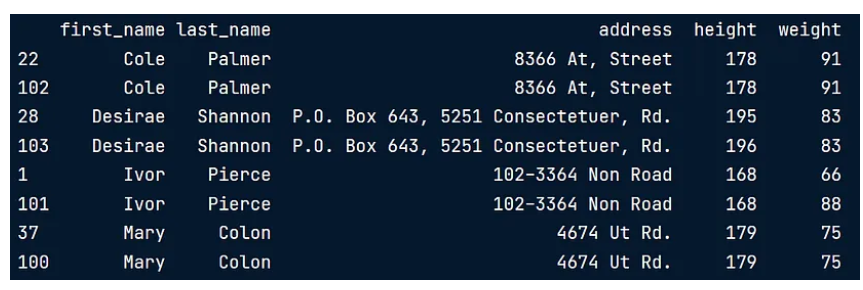

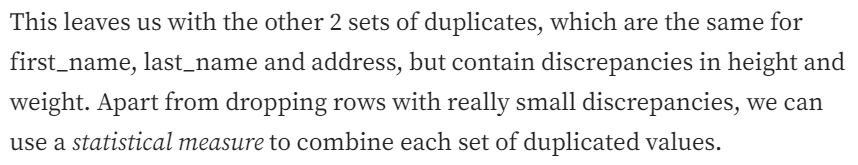

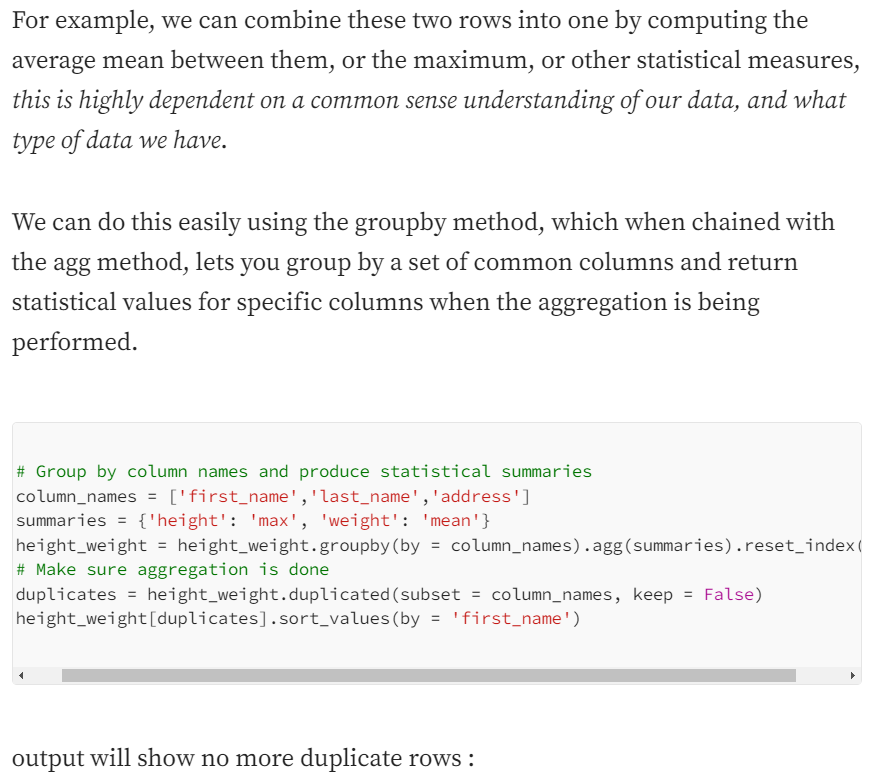

**Code explanation:** we created a dictionary called summaries, which instructs groupby to return the maximum of duplicated rows for the height column, and the mean duplicated rows for the weight column. We then group height_weight by the column names defined earlier, and chained it with the agg method, which takes in the summaries dictionary we created. We chain this entire line with the dot-reset_index() method, so that we can have numbered indices in the final output. We can verify that there are no more duplicate values by running the duplicated method again, and use brackets to output duplicate rows.

# 2. Text and Categorical Data Problems

To run machine learning models on categorical data, they are often coded as numbers. Since categorical data represent a predefined set of categories, they can’t have values that go beyond these predefined categories.

## a. Membership constraints

### Example 6

In [32]:
data = {'name':['a','b','c','d','e','f'],
        'birthdate':['2019-10-20','2020-07-08','2019-08-12','2019-03-17','2019-12-17','2020-04-27'],
        'blood_type':['B-','A-','O+','O-','Z+','A+']}
df = pd.DataFrame(data)
df

,name,birthdate,blood_type
0,a,2019-10-20,B-
1,b,2020-07-08,A-
2,c,2019-08-12,O+
3,d,2019-03-17,O-
4,e,2019-12-17,Z+
5,f,2020-04-27,A+


In [33]:
categories = pd.DataFrame({'blood_type':['B-','A-','O+','O-','A+','AB+','AB-']})
categories

,blood_type
0,B-
1,A-
2,O+
3,O-
4,A+
5,AB+
6,AB-


So we can see here that the 5th row of study data has a blood type Z+ which isnt on from the categories data. The categories dataframe will help us systematically spot all rows with these inconsistencies.

left anti join of A and B, and are returning the columns of DataFrames A and B for values only found in A of the common column between them being joined on.

Inner joins, return only the data that is contained in both DataFrames. For example, an inner join of A and B, would return columns from both DataFrames for values only found in A and B, of the common column between them being joined on.

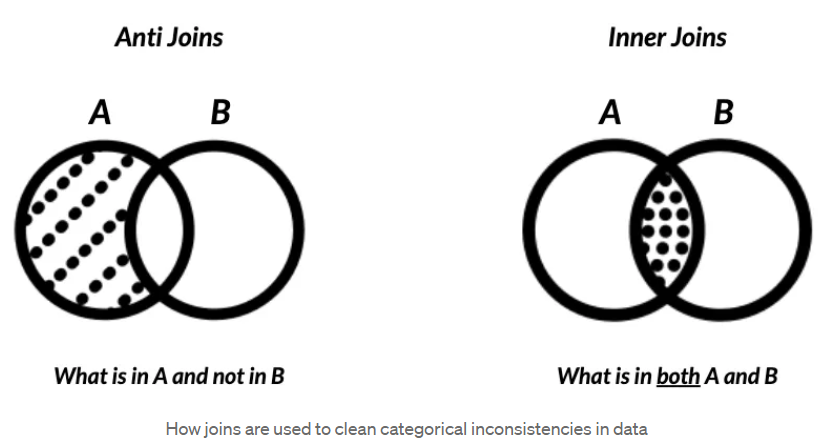

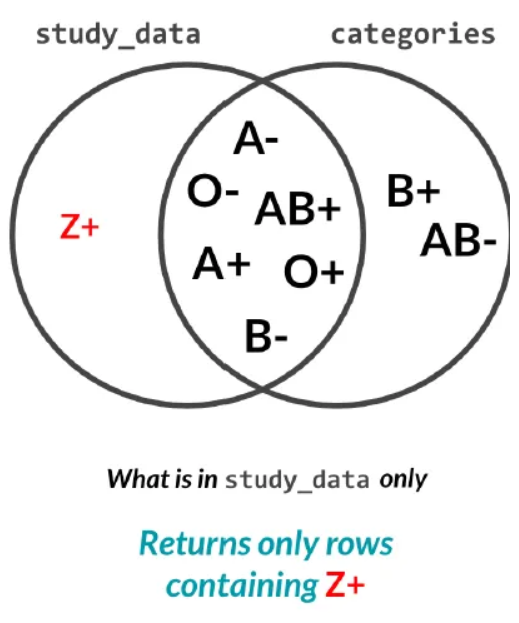

In [34]:
inconsistent_categories = set(df['blood_type']).difference(categories['blood_type'])
inconsistent_categories

{'Z+'}

In [35]:
# Get and print rows with inconsistent categories
inconsistent_rows = df['blood_type'].isin(inconsistent_categories)
df[inconsistent_rows]

,name,birthdate,blood_type
4,e,2019-12-17,Z+


To drop inconsistent rows and keep ones that are only consistent. We just use the tilde symbol while subsetting which returns everything except inconsistent rows.

In [36]:
inconsistent_data = df[inconsistent_rows]
# Drop inconsistent categories and get consistent data only
consistent_data = df[~inconsistent_rows]
consistent_data

,name,birthdate,blood_type
0,a,2019-10-20,B-
1,b,2020-07-08,A-
2,c,2019-08-12,O+
3,d,2019-03-17,O-
5,f,2020-04-27,A+


## b. Categorical variables

### Example 7

In [37]:
data = {'name':['a','b','c','d','e','f'],
        'marriage_status':['unmarried','married','MARRIED','MARRIED','unmarried','UNMARRIED'],
        'blood_type':['B-','A-','O+','O-','Z+','A+']}
df = pd.DataFrame(data)
df

,name,marriage_status,blood_type
0,a,unmarried,B-
1,b,married,A-
2,c,MARRIED,O+
3,d,MARRIED,O-
4,e,unmarried,Z+
5,f,UNMARRIED,A+


In [38]:
marriage_status = df['marriage_status']
marriage_status.value_counts()

unmarried    2
MARRIED      2
married      1
UNMARRIED    1
Name: marriage_status, dtype: int64

To deal with this, we can either capitalize or lowercase the marriage_status column. This can be done with the str-dot-upper() or dot-lower() functions respectively.

In [39]:
# Option 1: capitalize
df2 = df.copy()
df2['marriage_status'] = df2['marriage_status'].str.upper()
marriage_status = df2['marriage_status']
marriage_status.value_counts()

UNMARRIED    3
MARRIED      3
Name: marriage_status, dtype: int64

In [40]:
# Option 1: lowercase
df3 = df.copy()
df3['marriage_status'] = df3['marriage_status'].str.lower()
marriage_status = df3['marriage_status']
marriage_status.value_counts()

unmarried    3
married      3
Name: marriage_status, dtype: int64

### Example 8

using the cut() method : lets us define category cutoff ranges with the bins argument. It takes in a list of cutoff points for each category, with the final one being represented with 6+.

In [49]:
df3['household_income'] = [1,5,8,2,3,4]
df3

,name,marriage_status,blood_type,household_income
0,a,unmarried,B-,1
1,b,married,A-,5
2,c,married,O+,8
3,d,married,O-,2
4,e,unmarried,Z+,3
5,f,unmarried,A+,4


In [53]:
# Using cut() - create category ranges and names
group_names = ['0-3', '4-5', '6+']
# Create income group column
df3['income_group'] = pd.cut(df3['household_income'], bins=3,
    labels=group_names)
df3

,name,marriage_status,blood_type,household_income,income_group
0,a,unmarried,B-,1,0-3
1,b,married,A-,5,4-5
2,c,married,O+,8,6+
3,d,married,O-,2,0-3
4,e,unmarried,Z+,3,0-3
5,f,unmarried,A+,4,4-5


### Example 9

Mapping categories to fewer ones :
Lets say we have an operating system column where values lie as follows:
operating_system column is: ‘Microsoft’, ‘MacOS’, ‘IOS’, ‘Android’, ‘Linux’
operating_system column should become: ‘DesktopOS’, ‘MobileOS’

In [54]:
df3['operating_system'] = ['Microsoft','MacOS','Linux','IOS','Android','Linux']
mapping = {'Microsoft':'DesktopOS', 'MacOS':'DesktopOS', 'Linux':'DesktopOS',
            'IOS':'MobileOS', 'Android':'MobileOS'}
df3['operating_system_abb'] = df3['operating_system'].replace(mapping)
df3

,name,marriage_status,blood_type,household_income,income_group,operating_system,operating_system_abb
0,a,unmarried,B-,1,0-3,Microsoft,DesktopOS
1,b,married,A-,5,4-5,MacOS,DesktopOS
2,c,married,O+,8,6+,Linux,DesktopOS
3,d,married,O-,2,0-3,IOS,MobileOS
4,e,unmarried,Z+,3,0-3,Android,MobileOS
5,f,unmarried,A+,4,4-5,Linux,DesktopOS


In [55]:
df3['operating_system_abb'].unique()

array(['DesktopOS', 'MobileOS'], dtype=object)

## c. Cleaning text data

In [79]:
fake = Faker()
#name(), address(), text(), email(), country(), latitude(), longitude(), url(), phone_number() ...
data = {}
name, phone = [], []
for i in range(10):
    name.append(fake.name())
    phone.append(fake.phone_number())
data['Full name'] = name
data['Phone number'] = phone
df = pd.DataFrame(data)
df

,Full name,Phone number
0,Maria Roberts,4878597055
1,Carla Harvey,+1-909-561-3017x95104
2,Jesse Small,722-542-7233x258
3,Jermaine Butler,001-238-947-9360x107
4,Kristen Wilkinson,951-994-2408
5,Ashley Jones,888.637.0301
6,William Schultz,(627)202-5884x16964
7,Brenda Moore,739.461.4566x625
8,Stephen Garrett,864-316-6338x2041
9,Nicole Brooks,855.203.8587


If we wanted to feed these phone numbers into an automated call system, or create a report discussing the distribution of users by area code, we couldn’t really do so without uniform phone numbers.

What we expect :
1. Phone numbers are aligned to begin only digits
2. Any number different to 10 digit value is replaced with NaN to represent a missing value, and
3. All the dashes, dots, 'x', parenthesis, '+', have been removed

In [75]:
df.dtypes

Full name       object
Phone number    object
dtype: object

In [80]:
mapping = {'(':'', ')':'', '-':'', '.':'', 'x':'', '+':''}
mapeo = ['(', ')', '-']
change = ['', '', '']
for key, value in mapping.items():
    df['Phone number'] = df['Phone number'].str.replace(key, value, regex=False)
df

,Full name,Phone number
0,Maria Roberts,4878597055
1,Carla Harvey,1909561301795104
2,Jesse Small,7225427233258
3,Jermaine Butler,0012389479360107
4,Kristen Wilkinson,9519942408
5,Ashley Jones,8886370301
6,William Schultz,627202588416964
7,Brenda Moore,7394614566625
8,Stephen Garrett,86431663382041
9,Nicole Brooks,8552038587


In [81]:
digits = df['Phone number'].str.len()
df.loc[digits != 10, "Phone number"] = np.nan
df

,Full name,Phone number
0,Maria Roberts,4878597055
1,Carla Harvey,NaN
2,Jesse Small,NaN
3,Jermaine Butler,NaN
4,Kristen Wilkinson,9519942408
5,Ashley Jones,8886370301
6,William Schultz,NaN
7,Brenda Moore,NaN
8,Stephen Garrett,NaN
9,Nicole Brooks,8552038587


### Example 11

Regular Expressions for more complicated examples :

In [82]:
#name(), address(), text(), email(), country(), latitude(), longitude(), url(), phone_number() ...
data = {}
name, phone = [], []
for i in range(10):
    name.append(fake.name())
    phone.append(fake.phone_number())
data['Full name'] = name
data['Phone number'] = phone
df = pd.DataFrame(data)
df

,Full name,Phone number
0,Benjamin Hall,350.456.6289
1,Shirley Kelley,9383966326
2,Karla Haas,9715416525
3,Jennifer Burns,427-426-6567x085
4,Lauren Mendoza,(974)541-8437
5,Tammy Roy,329.644.2546x6854
6,Courtney Marsh,+1-930-301-2546x012
7,Monica Garcia,001-804-292-9509x47339
8,Bridget Romero,(582)310-2793
9,Christopher Miller,899-202-2585x440


How can we clean a phone number column that looks like this for example? Where phone numbers can contain a range of symbols from plus signs, dashes, parenthesis and maybe more. This is where regular expressions come in. Regular expressions give us the ability to search for any pattern in text data, like only digits for example. They are like control + find in your browser, but way more dynamic and robust.

In [84]:
df['Phone number'] = df['Phone number'].str.replace(r'\D', '', regex=True)
df

,Full name,Phone number
0,Benjamin Hall,3504566289
1,Shirley Kelley,9383966326
2,Karla Haas,9715416525
3,Jennifer Burns,4274266567085
4,Lauren Mendoza,9745418437
5,Tammy Roy,32964425466854
6,Courtney Marsh,19303012546012
7,Monica Garcia,001804292950947339
8,Bridget Romero,5823102793
9,Christopher Miller,8992022585440


# 3. Advanced Data Problems

## a. Uniformity

We will see unit uniformity. For example, we can have temperature data that has values in both Fahrenheit and Celsius, weight data in Kilograms and in stones, dates in multiple formats, and so on. Verifying unit uniformity is imperative to having accurate analysis.

### Example 12

In [94]:
#name(), address(), text(), email(), country(), latitude(), longitude(), url(), phone_number(), date() ...
data = {}
date, phone = [], []
data['Date'] = [fake.date() for i in range(10)]
data['Temperature'] = [np.random.randint(10, 25) for i in range(10)]
df = pd.DataFrame(data)
df

,Date,Temperature
0,2012-06-17,12
1,1990-05-16,23
2,1986-08-30,19
3,1984-09-15,17
4,1994-12-27,19
5,1984-03-22,12
6,1983-04-01,19
7,2022-02-16,23
8,1978-12-23,21
9,2014-09-03,11


In [99]:
df.loc[3, 'Temperature'] = 62.6
df.loc[5, 'Temperature'] = 66.6

In [100]:
df

,Date,Temperature
0,2012-06-17,12.0
1,1990-05-16,23.0
2,1986-08-30,19.0
3,1984-09-15,62.6
4,1994-12-27,19.0
5,1984-03-22,66.6
6,1983-04-01,19.0
7,2022-02-16,23.0
8,1978-12-23,21.0
9,2014-09-03,11.0


We can see that unless a major climate event occurred, those values (62.6, 66.6) here is most likely Fahrenheit, not Celsius. Let’s confirm the presence of these values visually.

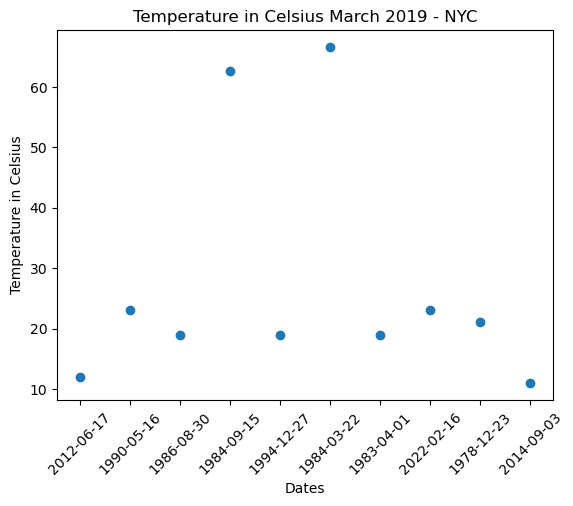

In [103]:
plt.scatter(x='Date', y='Temperature', data=df)
plt.title('Temperature in Celsius March 2019 - NYC')
plt.xlabel('Dates')
plt.ylabel('Temperature in Celsius')
plt.xticks(rotation=45)
plt.show()

**Treating Temperature Data :**

Steps to follow :
1. To convert our temperature data, we isolate all rows of temperature column where it is above 40 using the loc method.
2. We chose 40 because it’s a common sense maximum for Celsius temperatures in New York City.[ Domain Knowledge]
3. We then convert these values to Celsius using the formula from web, and reassign them to their respective Fahrenheit values in temperatures.
4. We can make sure that our conversion was correct with an assert statement, by making sure the maximum value of temperature is less than 40.

In [107]:
temp_fah = df.loc[df['Temperature'] > 40, 'Temperature']
temp_cels = (temp_fah-32)*(5/9)
df.loc[df['Temperature'] > 40, 'Temperature'] = temp_cels
assert df['Temperature'].max() < 40

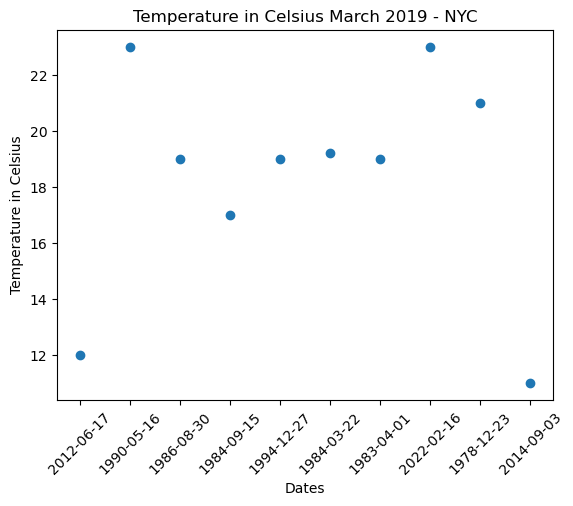

In [108]:
plt.scatter(x='Date', y='Temperature', data=df)
plt.title('Temperature in Celsius March 2019 - NYC')
plt.xlabel('Dates')
plt.ylabel('Temperature in Celsius')
plt.xticks(rotation=45)
plt.show()

### Example 13

Another interesting example dealing with dates which is a very common data inconsitency issues which needs to be dealt with :

In [133]:
#name(), address(), text(), email(), country(), latitude(), longitude(), url(), phone_number(), date() ...
data = {}
date, name = [], []
data['Date'] = [fake.date() for i in range(10)]
data['name'] = [fake.name() for i in range(10)]
df = pd.DataFrame(data)
df

,Date,name
0,1994-10-21,Scott Reed
1,2001-06-14,Rachel Williams
2,1974-11-01,Katie Moon
3,1990-01-12,Jason Williams
4,1975-11-12,Steven Ramirez
5,2021-04-13,Cindy Shaw
6,1998-08-25,Stephen Hughes
7,2019-06-19,Emily Rowe
8,2006-04-21,David Fuller
9,1997-06-09,Terri White


In [134]:
df[['first_name', 'last_name']] = df['name'].str.split(n=1, expand=True)
df

,Date,name,first_name,last_name
0,1994-10-21,Scott Reed,Scott,Reed
1,2001-06-14,Rachel Williams,Rachel,Williams
2,1974-11-01,Katie Moon,Katie,Moon
3,1990-01-12,Jason Williams,Jason,Williams
4,1975-11-12,Steven Ramirez,Steven,Ramirez
5,2021-04-13,Cindy Shaw,Cindy,Shaw
6,1998-08-25,Stephen Hughes,Stephen,Hughes
7,2019-06-19,Emily Rowe,Emily,Rowe
8,2006-04-21,David Fuller,David,Fuller
9,1997-06-09,Terri White,Terri,White


In [135]:
df.loc[1, 'Date'] = '2001/06/14'
df.loc[4, 'Date'] = 'March 3rd, 2019'
df.loc[7, 'Date'] = '27/06/19'
df

,Date,name,first_name,last_name
0,1994-10-21,Scott Reed,Scott,Reed
1,2001/06/14,Rachel Williams,Rachel,Williams
2,1974-11-01,Katie Moon,Katie,Moon
3,1990-01-12,Jason Williams,Jason,Williams
4,"March 3rd, 2019",Steven Ramirez,Steven,Ramirez
5,2021-04-13,Cindy Shaw,Cindy,Shaw
6,1998-08-25,Stephen Hughes,Stephen,Hughes
7,27/06/19,Emily Rowe,Emily,Rowe
8,2006-04-21,David Fuller,David,Fuller
9,1997-06-09,Terri White,Terri,White


We will use the datetime() function here

In [136]:
df['Birthday'] = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce')
df

,Date,name,first_name,last_name,Birthday
0,1994-10-21,Scott Reed,Scott,Reed,1994-10-21
1,2001/06/14,Rachel Williams,Rachel,Williams,2001-06-14
2,1974-11-01,Katie Moon,Katie,Moon,1974-11-01
3,1990-01-12,Jason Williams,Jason,Williams,1990-01-12
4,"March 3rd, 2019",Steven Ramirez,Steven,Ramirez,2019-03-03
5,2021-04-13,Cindy Shaw,Cindy,Shaw,2021-04-13
6,1998-08-25,Stephen Hughes,Stephen,Hughes,1998-08-25
7,27/06/19,Emily Rowe,Emily,Rowe,2019-06-27
8,2006-04-21,David Fuller,David,Fuller,2006-04-21
9,1997-06-09,Terri White,Terri,White,1997-06-09


## b. Cross field validation

### Example 13

In [137]:
data = {'flight_nmuber':['DL140', 'BA248', 'MEA124'],
        'economy_class':[100,130,100],
        'business_class':[60,100,50],
        'first_class':[40,70,50],
        'total_passengers':[200,300,200]}
df = pd.DataFrame(data)
df

,flight_nmuber,economy_class,business_class,first_class,total_passengers
0,DL140,100,60,40,200
1,BA248,130,100,70,300
2,MEA124,100,50,50,200


we can do cross field validation by summing economy, business and first class values and making sure they are equal to the total passengers on the plane.

In [139]:
sum_classes = df[['economy_class', 'business_class', 'first_class']].sum(axis = 1)
sum_classes

0    200
1    300
2    200
dtype: int64

In [141]:
passenger_equ = sum_classes == df['total_passengers']
passenger_equ

0    True
1    True
2    True
dtype: bool

In [147]:
# Find and filter out rows with inconsistent passenger totals
inconsistent_pass = df[~passenger_equ]
consistent_pass = df[passenger_equ]
print(inconsistent_pass)
print('='*80)
print(consistent_pass)

Empty DataFrame
Columns: [flight_nmuber, economy_class, business_class, first_class, total_passengers]
Index: []
  flight_nmuber  economy_class  business_class  first_class  total_passengers
0         DL140            100              60           40               200
1         BA248            130             100           70               300
2        MEA124            100              50           50               200


### Example 14

Here’s another example containing user IDs, birthdays and age values for a set of users.
We can for example make sure that the age and birthday columns are correct by subtracting the number of years between today’s date and each birthday.

In [157]:
#name(), address(), text(), email(), country(), latitude(), longitude(), url(), phone_number(), date() ...
data = {}
data['user_id'] = [np.random.randint(32000, 99000) for i in range(10)]
data['Age'] = [np.random.randint(20, 30) for i in range(10)]
data['Birthday'] = [fake.date() for i in range(10)]
df = pd.DataFrame(data)
df

,user_id,Age,Birthday
0,36009,25,1996-05-18
1,57204,25,2015-07-07
2,70508,25,2018-05-04
3,62609,26,1974-06-26
4,32020,21,1987-02-06
5,48747,20,2011-01-24
6,55969,25,1986-06-22
7,32686,29,2011-03-29
8,90209,28,1985-03-16
9,70127,23,1980-02-29


In [160]:
#Cambiar algunas edades que si corresponden con la fecha birthday
df.loc[3, 'Age'] = 50
df.loc[5, 'Age'] = 13
df.loc[7, 'Age'] = 13
df.loc[8, 'Age'] = 39

In [161]:
today = dt.date.today()
df['Birthday'] = pd.to_datetime(df['Birthday'])
age_manual = today.year - df['Birthday'].dt.year
age_equ = age_manual == df['Age']
age_equ

0    False
1    False
2    False
3     True
4    False
5     True
6    False
7     True
8     True
9    False
dtype: bool

In [162]:
inconsistent_age = df[~age_equ]
consistent_age = df[age_equ]
print(inconsistent_age)
print('='*80)
print(consistent_age)

   user_id  Age   Birthday
0    36009   25 1996-05-18
1    57204   25 2015-07-07
2    70508   25 2018-05-04
4    32020   21 1987-02-06
6    55969   25 1986-06-22
9    70127   23 1980-02-29
   user_id  Age   Birthday
3    62609   50 1974-06-26
5    48747   13 2011-01-24
7    32686   13 2011-03-29
8    90209   39 1985-03-16


In [169]:
df['age_correct'] = age_manual
df

,user_id,Age,Birthday,age_correct
0,36009,25,1996-05-18,28
1,57204,25,2015-07-07,9
2,70508,25,2018-05-04,6
3,62609,50,1974-06-26,50
4,32020,21,1987-02-06,37
5,48747,13,2011-01-24,13
6,55969,25,1986-06-22,38
7,32686,13,2011-03-29,13
8,90209,39,1985-03-16,39
9,70127,23,1980-02-29,44


## c. Completeness

Missing data is one of the most common and most important data cleaning problems. Essentially, missing data is when no data value is stored for a variable in an observation. Missing data is most commonly represented as NA or NaN, but can take on arbitrary values like 0 or dot.

### Example 15

In [181]:
CO2 = [0, 0.8, np.nan, 1.8, 1.2, 1.5]
Temperature = [16.8, 18.7, -40, 19.6, 11.2, 20.5, 18.5, 17.8]
data = {}
n_data = 20
data['Date'] = [fake.date() for i in range(n_data)]
data['Temperature'] = [np.random.choice(Temperature) for i in range(n_data)]
data['CO2'] = [np.random.choice(CO2) for i in range(n_data)]

df = pd.DataFrame(data)
df

,Date,Temperature,CO2
0,1999-07-30,17.8,0.8
1,1977-04-12,19.6,1.8
2,2021-03-27,18.5,0.0
3,1993-09-22,20.5,1.5
4,1996-12-18,18.7,1.5
5,2022-01-02,17.8,NaN
6,2003-10-09,11.2,1.8
7,1973-03-18,16.8,0.8
8,1997-05-08,11.2,1.5
9,1991-05-14,20.5,1.8


In [182]:
df.loc[5, 'Temperature'] = -35.0
df.loc[17, 'Temperature'] = -49.2

In [183]:
df.isna().sum()

Date           0
Temperature    0
CO2            4
dtype: int64

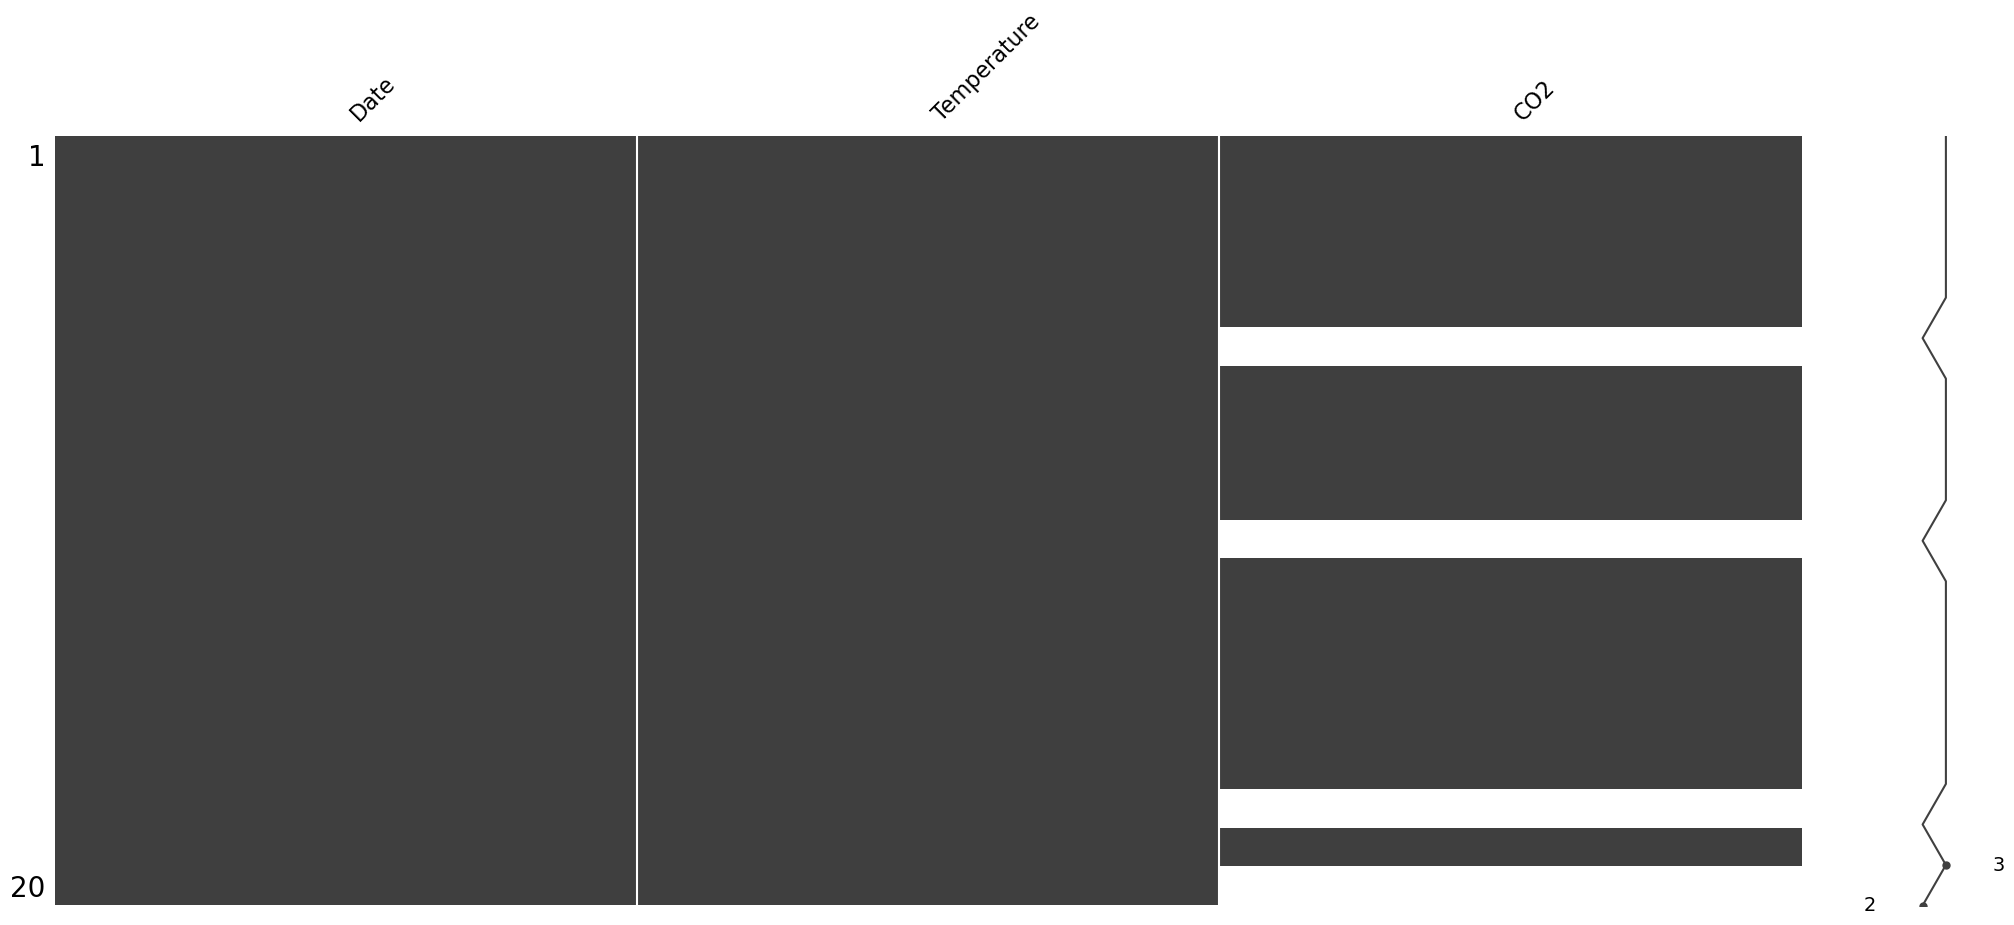

In [184]:
msno.matrix(df)
plt.show()

This matrix essentially shows how missing values are distributed across a column. We see that missing CO2 values are randomly scattered throughout the column, but is that really the case? Let’s dig deeper.

step1. We first isolate the rows of df with missing CO2 values in one DataFrame, and complete CO2 values in another.

In [185]:
# Isolate missing and complete values aside
missing = df[df['CO2'].isna()]
complete = df[~df['CO2'].isna()]
# Describe complete DataFramee
complete.describe()

,Temperature,CO2
count,16.000000,16.000000
mean,17.825000,1.237500
std,2.872745,0.605392
min,11.200000,0.000000
25%,17.550000,0.800000
50%,18.500000,1.500000
75%,19.825000,1.800000
max,20.500000,1.800000


In [186]:
# Describe missing DataFramee
missing.describe()

,Temperature,CO2
count,4.000000,0.0
mean,-41.050000,NaN
std,5.922556,NaN
min,-49.200000,NaN
25%,-42.300000,NaN
50%,-40.000000,NaN
75%,-38.750000,NaN
max,-35.000000,NaN


We see that for all missing values of CO2, they occur at really low temperatures, with the mean temperature at -41.05 degrees and a minimum and maximum of -49.2 and -35.0 respectively. Let’s confirm this visually with the missngno package.

Step2. We first sort the DataFrame by the temperature column. Then we input the sorted dataframe to the matrix function from msno. This leaves us with this matrix.

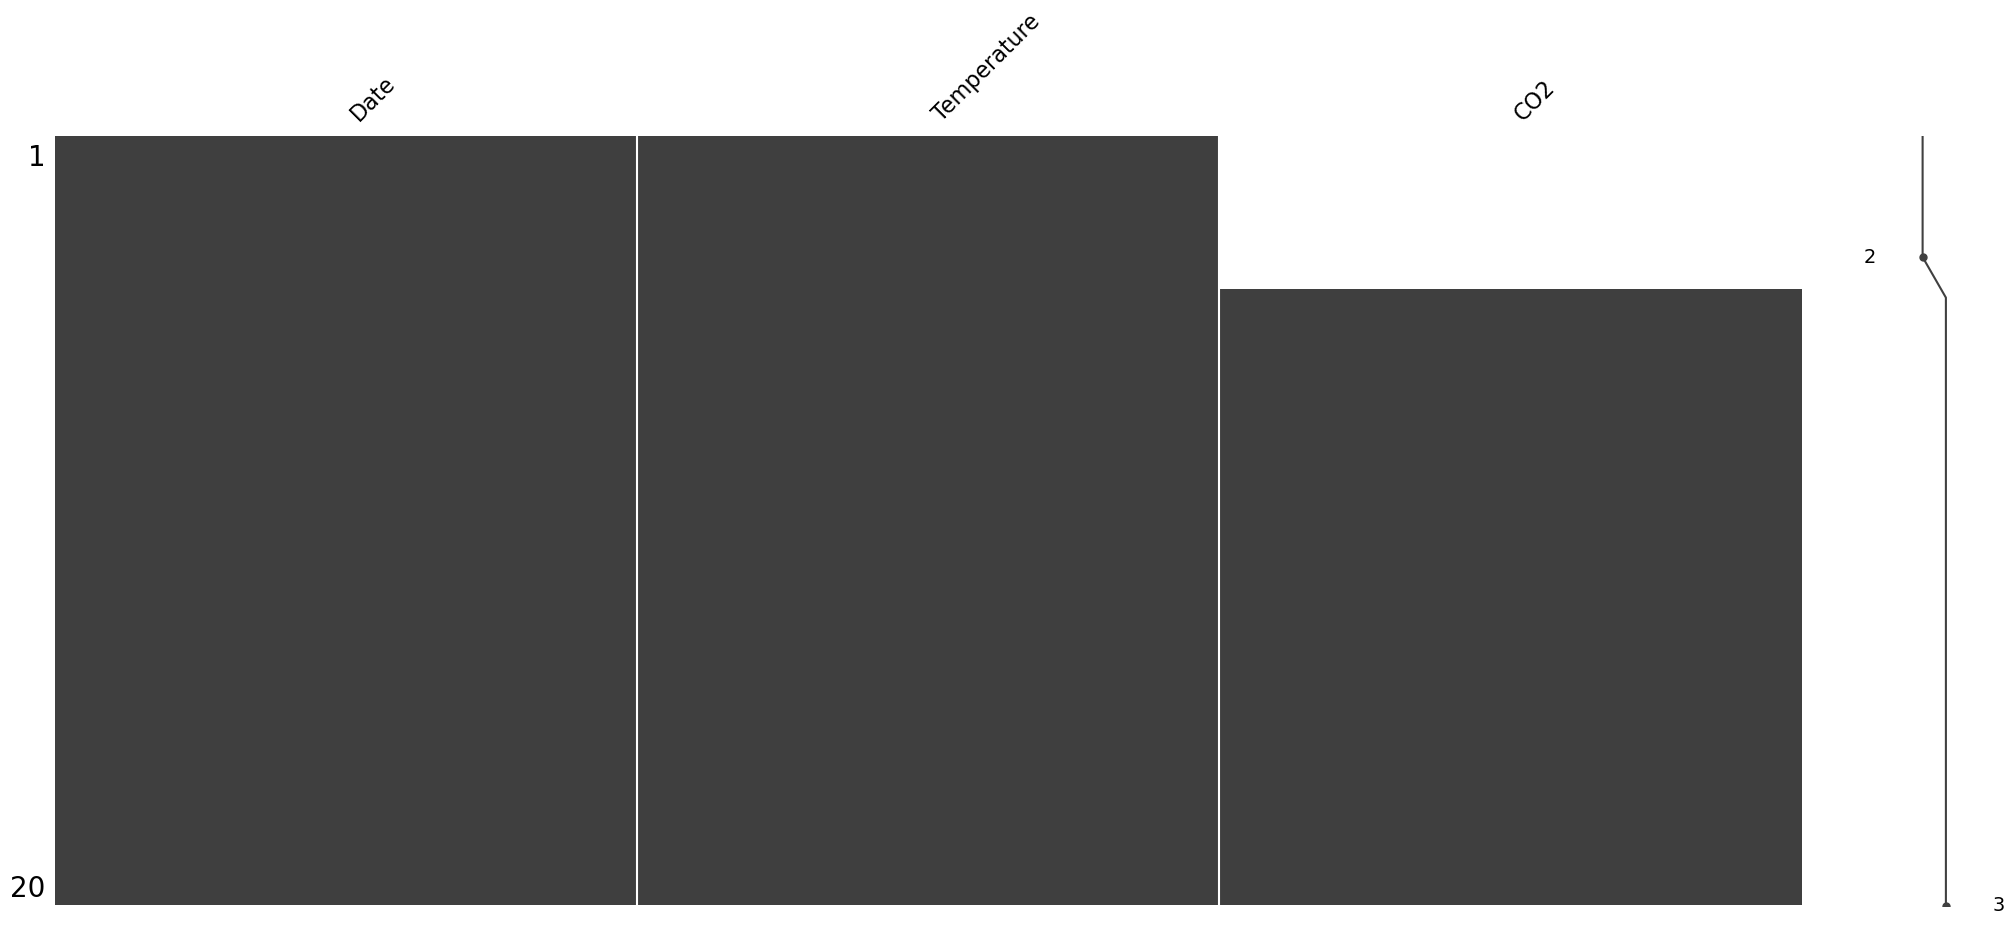

In [187]:
sorted_df = df.sort_values(by = 'Temperature')
msno.matrix(sorted_df)
plt.show()

Notice how all missing values are on the top? This is because values are sorted from smallest to largest by default. This essentially confirms that CO2 measurements are lost for really low temperatures. Must be a sensor failure!

**Missingness Types :**

We have seen one type of missingness in the above example. This is called Missing at random data : is when there is a relationship between missing data and other observed values.

The other 2 types are :

Missing completely at random data : when there missing data completely due to randomness, and there is no relationship between missing data and remaining values, such data entry errors.

And, missing not at random : there is a systematic relationship between the missing data and unobserved values.

### Example 16

An example of missing not at random :

For example, when it’s really hot outside, the thermometer might stop working, so we don’t have temperature measurements for days with high temperatures. However, we have no way to tell this just from looking at the data since we can’t actually see what the missing temperatures are.

Dealing with missing data — simple approaches :

1. Dropping missing values
2. Impute with statistical measures (mean, median, mode..)
3. Imputing using an algorithmic approach
4. Impute with machine learning models

First approach (1. Dropping missing values):

We can drop missing values, by using the dot dropna method, alongside the subset argument which lets us pick which column’s missing values to drop.

In [188]:
df_dropped = df.dropna(subset=['CO2'])
df_dropped

,Date,Temperature,CO2
0,1999-07-30,17.8,0.8
1,1977-04-12,19.6,1.8
2,2021-03-27,18.5,0.0
3,1993-09-22,20.5,1.5
4,1996-12-18,18.7,1.5
6,2003-10-09,11.2,1.8
7,1973-03-18,16.8,0.8
8,1997-05-08,11.2,1.5
9,1991-05-14,20.5,1.8
11,1978-08-27,20.5,1.2


Second approach (2. Impute with statistical measures (mean, median, mode..)):

We can also replace the missing values of CO2 with the mean value of CO2, by using the fillna method

In [190]:
CO2_mean = df['CO2'].mean()
df_imputed = df.fillna({'CO2':CO2_mean})
df_imputed

,Date,Temperature,CO2
0,1999-07-30,17.8,0.8000
1,1977-04-12,19.6,1.8000
2,2021-03-27,18.5,0.0000
3,1993-09-22,20.5,1.5000
4,1996-12-18,18.7,1.5000
5,2022-01-02,-35.0,1.2375
6,2003-10-09,11.2,1.8000
7,1973-03-18,16.8,0.8000
8,1997-05-08,11.2,1.5000
9,1991-05-14,20.5,1.8000


# 4. Record Linkage

**String Similarity and Minimum Edit Distance :**

String similarity is the process of determining how close 2 strings are and its done using a systematic way of Minimum Edit Distance

### Example 17

For example, let’s take a look at the following two words: intention, and execution.

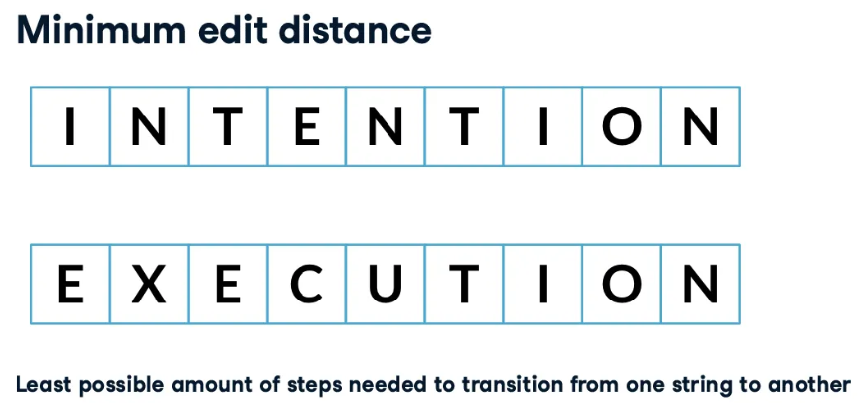

The minimum edit distance between them is the <i>least possible amount of steps, that could get us from the word intention to execution</i>, with the available operations being : inserting new characters, deleting them, substituting them, and transposing consecutive characters.

How do we get from INTENTION to EXECUTION ?

step1. deleting I from intention

step2. adding C between E and N

step3. substitute the first N with E

step4. T with X and

step5. N with U

This leads to a Minimum edit distance of 5.

<h3>The lower the edit distance, the closer two words are.</h3>

## a. String comparison

Various algorithms and corresponding packages are available to measure minimum distance and for our example we will pick up Levenshtein distance since it’s the most general form of string matching by using the thefuzz package.

### Example 18

In [193]:
# Lets us compare between two strings
# Compare reeding vs reading
fuzz.WRatio('Reeding', 'Reading')

86

For any comparison function using thefuzz, the output is a score from 0 to 100 with 0 being not similar at all, 100 being an exact match.

In [194]:
fuzz.WRatio('Intention', 'Execution')

56

### Example 19

In [196]:
categories = pd.DataFrame({'state':['California', 'New York']})
categories

,state
0,California
1,New York


In [202]:
data = {'state': ['California', 'cali', 'Cali', 'Calefornie','New York', 'New York City', 'Calfornia', 'NYC',
                  'Calefernia', 'Newyork']}
data['id'] = [i for i in range(len(data['state']))]
df = pd.DataFrame(data)
df

,state,id
0,California,0
1,cali,1
2,Cali,2
3,Calefornie,3
4,New York,4
5,New York City,5
6,Calfornia,6
7,NYC,7
8,Calefernia,8
9,Newyork,9


**Comparison with arrays :**

We can also compare a string with an array of strings by using the extract function from the process module from fuzzy wuzzy. Extract takes in a string, an array of strings, and the number of possible matches to return ranked from highest to lowest. It returns a list of tuples with 3 elements, the first one being the matching string being returned, the second one being its similarity score, and the third one being its index in the array.

In [212]:
# For each correct category
for state in categories['state']:
    matches = process.extract(state, df['state'], limit=df.shape[0])
    # For each potential match match
    for potential_match in matches:
        # If high similarity score
        if potential_match[1] >= 80:
            # Replace typo with correct category
            df.loc[df['state'] == potential_match[0], 'state'] = state

In [213]:
df

,state,id
0,California,0
1,California,1
2,California,2
3,California,3
4,New York,4
5,New York,5
6,California,6
7,NYC,7
8,California,8
9,New York,9


In [223]:
df.loc[df['state'] == 'NYC', 'state'] = 'New York'
df

,state,id
0,California,0
1,California,1
2,California,2
3,California,3
4,New York,4
5,New York,5
6,California,6
7,New York,7
8,California,8
9,New York,9


## b. Generating pairs

### Example 20

**Step1. Generating Pairs**

In [240]:
data1 = {'given_name':['michaela', 'courtney', 'basilis'],
         'surname':['neumann', 'strauss', 'rochelle'],
         'date_birthday':[19141111, 19161214, 19154758],
         'suburb':['winston hills', 'richlands', 'windermer'],
         'state':['cal', 'txs', 'ny']}
data2 = {'given_name':['elton', 'mitchell', 'john'],
         'surname':[np.nan, 'maxon', 'mixten'],
         'date_birthday':[19641111, 19361214, 19454758],
         'suburb':['windermer', 'north ryde', 'season wheel'],
         'state':['ny', 'cal', 'ny']}
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

In [241]:
df1

,given_name,surname,date_birthday,suburb,state
0,michaela,neumann,19141111,winston hills,cal
1,courtney,strauss,19161214,richlands,txs
2,basilis,rochelle,19154758,windermer,ny


In [242]:
df2

,given_name,surname,date_birthday,suburb,state
0,elton,NaN,19641111,windermer,ny
1,mitchell,maxon,19361214,north ryde,cal
2,john,mixten,19454758,season wheel,ny


In [243]:
# Create indexing object
indexer = recordlinkage.Index()

# Generate pairs blocked on state
indexer.block('state')
pairs = indexer.index(df1, df2)

In [244]:
print(pairs)

MultiIndex([(0, 1),
            (2, 0),
            (2, 2)],
           )


**Step2. Find potential matches**

In [245]:
# Generate the pairs
pairs = indexer.index(df1, df2)
# Create a Compare object
compare_cl = recordlinkage.Compare()

# Find exact matches for pairs of date_of_birth and state
compare_cl.exact('date_birthday', 'date_birthday', label='date_birthday')
compare_cl.exact('state', 'state', label='state')
# Find similar matches for pairs of surname and address_1 using string similarity
compare_cl.string('surname', 'surname', threshold=0.85, label='surname')
compare_cl.string('suburb', 'suburb', threshold=0.85, label='suburb')

# Find matches
potential_matches = compare_cl.compute(pairs, df1, df2)
print(potential_matches)

     date_birthday  state  surname  suburb
0 1              0      1      0.0     0.0
2 0              0      1      0.0     1.0
  2              0      1      0.0     0.0


Since we’ve already generated our pairs, it’s time to find potential matches.
1. We first start by creating a comparison object using the recordlinkage dot compare function. This is similar to the indexing object we created while generating pairs, but this one is responsible for assigning different comparison procedures for pairs.
2. Let’s say there are columns for which we want exact matches between the pairs. To do that, we use the exact method. It takes in the column name in question for each DataFrame, which is in this case date_birthday and state, and a label argument which lets us set the column name in the resulting DataFrame.
3. Now in order to compute string similarities between pairs of rows for columns that have fuzzy values, we use the dot string method, which also takes in the column names in question, the similarity cutoff point in the threshold argument, which takes in a value between 0 and 1, which we here set to 0.85.
4. Finally to compute the matches, we use the compute function, which takes in the possible pairs, and the two DataFrames in question.

<i>Note that you need to always have the same order of DataFrames when inserting them as arguments when generating pairs, comparing between columns, and computing comparisons.</i>

The output is a multi index DataFrame, where the first index is the row index from the first DataFrame, or df1, and the second index is a list of all row indices in df2. The columns are the columns being compared, with values being 1 for a match, and 0 for not a match.

**Step3. Finding the pairs we want**

filter for rows where the sum of row values is higher than a certain threshold. Which in this case higher or equal to 2.

In [248]:
potential_matches[potential_matches.sum(axis=1) >= 2]

,,date_birthday,state,surname,suburb
2,0,0,1,0.0,1.0


**Keep in mind that we have briefly touched all the major topics involved and to be able to solve a variety of problems using any one of the above techniques will require a more in depth study and understanding of that technique which I have intentionally kept out of scope of this story.**